In [1]:
import midynet
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import fractions
import pandas as pd
import time

from tqdm import notebook as tqdm
from itertools import product
from midynet.statistics import Statistics
from midynet.utility import display
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter




display.setup_dir("./")

paths_to_figures = ["."]
paths_to_figures = list(map(pathlib.Path, paths_to_figures))

# path_to_data = pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/duality/figure2/")
# path_to_data = pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/duality/figure2/")
path_to_data = pathlib.Path(f"../../scripts/duality/data/figure7")

path_to_data.exists()


True

In [90]:
dynamics = ["glauber", "sis", "cowan"]

clabel = {
    "glauber": "coupling",
    "sis": "infection_prob",
    "cowan": "nu",
}
clabelpretty = {
    "glauber": r"J", "sis": r"\lambda", "cowan": r"\nu"
}
titles = ["Glauber", "SIS", "Cowan"]

def tau_label(t):
    if isinstance(t, int) or isinstance(t, float) and t.is_integer():

        if t > 0:
            return f"{int(t)}"
        elif t == 0:
            return f"1"
        else:
            return f"T - {abs(int(t))}"
    elif isinstance(t, float) and t>0 and t<1:
        frac = fractions.Fraction(t)
        return f"T / {frac.denominator}"
        if frac.numerator != 1:
            return f"{frac.numerator}" + tau_label
    raise ValueError()

recon = {}
pred = {}

xaxis = {}
aux1 = {}
aux2 = {}

for d in dynamics:
    p = path_to_data / f"exact-{d}/pastmutualinfo.pkl"
    df = pd.read_pickle(p)
    recon[d] = Statistics.from_dataframe(df, "recon")
    recon[d].rescale_(1./8)
    pred[d] = Statistics.from_dataframe(df, "pred")
    pred[d].rescale_(1./8)
    xaxis[d] = df["length"].values
    aux1[d] = df["past_length"].values
    aux2[d] = df[clabel[d]].values
    
    

  0%|          | 0/9 [00:00<?, ?it/s]

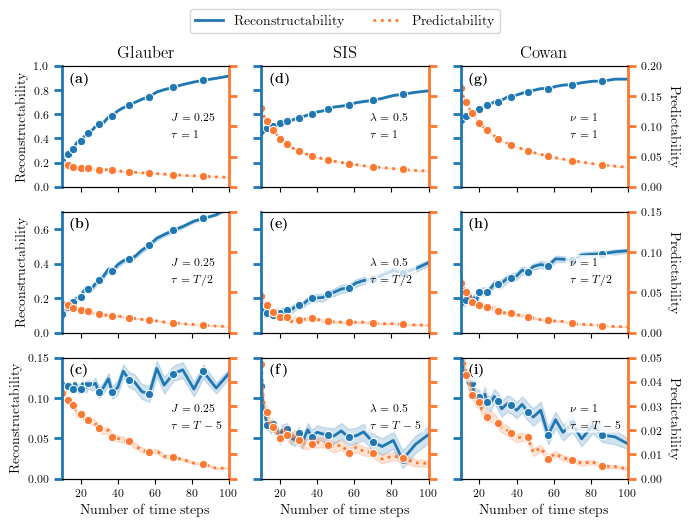

In [114]:
fig, ax = plt.subplots(3, 3, figsize=(7, 5), sharex=True, sharey=False)


rcolor = display.med_colors["blue"]
pcolor = display.dark_colors["orange"]
coupling_choice = dict(glauber=0.25, sis=0.5, cowan=1)

ymax = [1, 0.7, 0.15]
yymax = [0.2, 0.15, 0.05]
markersize = 4

pb = tqdm.tqdm(range(9))
for i, d in enumerate(dynamics):
    for j, t in enumerate([0, 0.5, -5.]):
        axx = ax[j, i].twinx()
        idx = np.logical_and(aux1[d] == t, xaxis[d] <= 100)
        idx = np.logical_and(idx, aux2[d] == coupling_choice[d])
        recon[d].lineplot(
            xaxis[d],
            color=rcolor,
            marker="o",
            linestyle="-",
            linewidth=2,
            ax=ax[j, i],
            indexes=idx,
            markevery=3,
#             markersize=markersize,
            n_boot=100 if t!=-5 else 1000
        )
        
        pred[d].lineplot(
            xaxis[d],
            color=pcolor,
            marker="o",
            linestyle="dotted",
            linewidth=2,
            ax=axx,
            indexes=idx,
            markevery=3,
#             markersize=markersize,
            n_boot=100 if t!=-5 else 1000
        )
    
        if i == 0:
            ax[j, i].set_ylabel("Reconstructability", fontsize=display.fontsizes["label"])
        else:
            ax[j, i].set_ylabel(None)
            ax[j, i].set_yticklabels([])
    
        if i == 2:
            axx.set_ylabel("Predictability", fontsize=display.fontsizes["label"], rotation=-90, va="bottom")
        else:
            axx.set_ylabel(None)
            axx.set_yticklabels([])
        
            
        axx.set_ylim([0, yymax[j]])
        ax[j, i].set_ylim([0, ymax[j]])
        
        ax[j, i].text(
                0.65, 0.55,
                rf"\noindent${clabelpretty[d]} = {coupling_choice[d]}$\\$\tau = {tau_label(t)}$",
                color="k",
                transform=ax[j, i].transAxes,
                fontsize=display.fontsizes["legend"],
                bbox=dict(boxstyle="round", color="white", alpha=0.75)
            )
        ax[j, i].tick_params(axis='y', color=rcolor, length=6, width=2)
        if j == 0:
            ax[j, i].set_title(titles[i], fontsize=display.fontsizes["large_label"])

        ax[j, i].set_xlabel("Number of time steps", fontsize=display.fontsizes["label"])
        ax[j, i].set_xlim([10, 100])
        ax[j, i].tick_params(axis="both", labelsize=display.fontsizes["tick"])
    
        axx.spines['left'].set_color(rcolor)
        axx.spines['left'].set_linewidth(2)
        axx.spines['right'].set_color(pcolor)
        axx.spines['right'].set_linewidth(2)
        axx.tick_params(axis='y', color=pcolor, length=6, width=2)
        axx.tick_params(axis='both', labelsize=display.fontsizes["tick"])
        pb.update()
        display.Label.plot(ax[j, i], loc="top left", box=True)
display.Label.clear()

handles = [
    display.get_label_line("Reconstructability", style=ax[j, i].get_lines()[0], marker="None"),
    display.get_label_line("Predictability", style=axx.get_lines()[0], marker="None"),
]
lg = fig.legend(handles=handles, loc="center", fontsize=display.fontsizes["label"], ncol=2, bbox_to_anchor=(0.5, 1.02))

pb.close()


fig.tight_layout()

for p, fmt in product(paths_to_figures, ["svg", "pdf", "png"]):
    fig.savefig(p / f"{fmt}/past-dependent-mutualinfo.{fmt}", bbox_extra_artists=(lg,), bbox_inches='tight')
